# A simple vectorized implementation of the Lattice Boltzmann Method

The Lattice Boltzmann Method is an elegant method to simulate fluid dynamics based on modelling distributions of particles moving and colliding on a lattice. The *Python*scripting language provides a clean programming paradigm to develop codes based on the Lattice Boltzmann Method, however in order to reach performance comparable to compiled languages, it needs to be carefully implemented, maximizing its vectorized tools, mostly integrated in the NumPy module. We go down here to the details of a Python implementation of an LBM code, with the purpose of offering a pedagogical tool for students and professional in the geosciences who are approaching this technique for the first time. The first half of the paper focuses on vectorization, and how this allows acceleration close to the speed of a compiled code, and how to exactly vectorize the LB Method. In the second part of the paper, we descrive a simple 2D parallel implementation using MPI and show how it linearly scales up to 1280 cores.  Finally we illustrate some applications such as wave propagation and fluid-flow through a simplified model of a rock matrix.

The Lattice Boltzmann Method allows fluid dynamics to be modelled by simulating the movement and collision of particle distributions on a discrete lattice in 2D or 3D. Lattice Boltzmann Methods have their origins in Lattice Gas Automata (LGA) in which particles move and collide on a discrete lattice representing a simplified discrete version of molecules moving and colliding in a gas. LGA were first proven in 1986 to yield the Navier-Stokes equations in the macroscopic limit. These initial LGA models were unconditionally stable and conserved mass and momentum perfectly. However, they were computationally expensive with averaging needed over space to obtain the macroscopic equations and furthermore, costly calculations were required to evaluate the collision term. Since the initial LGA models, the method has been extended to model distributions of particles moving and colliding on a lattice. In these lattice Boltzmann methods, one is solving the classical Boltzmann equation on a discrete lattice.

An efficient method to calculate the collision term via relaxation was proposed by Bhatnagar, Gross and Krook (BGK) in 1954, but only more recently has this been applied to the Lattice Boltzmann Method, enabling efficient algorithms to be developed. Since then, research and applications of the Lattice Boltzmann Method have undergone an explosion. In particular numerous studies have been conducted of thermal convection. Multi-phase methods have been developed as well, such as, and this remains a highly active research field.

## Numerical simulation methodology

The Lattice Boltzmann Method (LBM) involves simulating distributions of particles moving and colliding on a discrete lattice. In one time-step, the particle distributions can move by one lattice spacing along the orthogonal axes, or along diagonals. We use the standard notation in LBM denoted *DnQm* for a simulation in $D=n$ dimensions, and with $Q=m$ velocities on the discrete lattice. In the following, we restrict ourselves to 2D and use the $D2Q9$ Lattice Boltzmann lattice arrangement shown in the Figure. <img src="figures/figure1.jpg">

In this lattice, we define $f_\alpha ( {\bf x} , t)$ as the number density of particles moving in the $\alpha$-direction where the $Q=9$ velocities are given by\\
${\bf c}_\alpha = [(0,0),(1,0),(0,1),(-1,0),(0,-1),(1,1),(-1,1),(-1,-1),(-1,1)]^T$. This choice
means that ${\bf c}_0$ is the zero velocity vector and so represents stationary particles,
and ${\bf c}_\alpha = - {\bf c}_{\alpha + 2}$ for $\alpha = (1,2,5,6)$ are the velocities in the eight directions.
The lattice is unitary so the lattice spacing and time step are $\Delta x = \Delta t =1$.

The Lattice Boltzmann Method involves two steps: (a) movement and (b) collision of a distribution function. If we wish to model thermal convection or thermal-chemical convection, we just model additional distribution functions, representing the energy and the chemical component. In this paper, we focus on the technical aspects of implementing the LBM using {\it Python}. We therefore model a single distribution function, $f_\alpha$ representing the mass density of particles moving { and colliding} in the $\alpha$-direction on the discrete lattice. The evolution equation encompassing the two steps { of moving (streaming) and colliding} is given by

\begin{equation}
f_\alpha ( {\bf x} + {\bf c}_\alpha \Delta t , t + \Delta t ) \ = \ f_\alpha ( {\bf x} , t ) \ + \ \Delta f_\alpha^c ( {\bf x} , t ) \ \ \ ,
\label{eq:f}
\end{equation}

where $\Delta f_\alpha^c ( {\bf x} , t )$ is the collision term and represents the redistribution of particle number densities
at lattice site $({\bf x} , t)$ due to collisions. The collision term can be calculated exactly, but this is computationally
expensive and as such, is rarely done. Alternatively, the collision term can be calculated by the *BGK* method, in which case the distributions relax to the equilibrium distribution. The BGK method is computationally efficient and gives satisfactory results provided the distributions are not too far from equilibrium. The BGK collision term is given by

\begin{equation}
\Delta f_\alpha^c ( {\bf x} ,t ) \ = \ \left( { 1 \over \tau_f } \right) ( f_\alpha^{eq} ( {\bf x} , t ) - f_\alpha ( {\bf x} , t ) ) \ \ \ ,
\label{eq:Delta_f}
\end{equation}

where $f_\alpha^{eq} ( {\bf x} ,t )$ is used to denote the equilibrium distribution of $f_\alpha ( {\bf x} ,t )$. The equilibrium distribution is obtained by a Taylor expansion about the Boltzmann distribution given by

\begin{equation}
f^{eq} ( {\bf u} ) \ = \ {\rho \over {(2 \pi R T)^{D/2}}} \exp \left(- {{(\bf c - \bf u)^2} \over {2 R T}} \right ) \ \ \ ,
\label{Boltzmann-distribution}
\end{equation}

where $D$ is the number of dimensions.
Taking the Taylor's expansion of $f^{eq}$, we obtain

\begin{equation}
f^{eq} ( { \bf u} ) \ = \ {\rho \over {(2 \pi R T)^{D/2}}} \exp \left(- {{\bf c^2} \over {2 R T}} \right )
\left( 1 + {{{\bf c} \cdot {\bf u}} \over {R T}} + {1 \over 2} {{({\bf c} \cdot {\bf u} )^2 \over {( R T )^2}}} - {1 \over 2} {{{\bf u}^2} \over {R T}} \right) 
\ \ \ 
\label{Taylor-expansion}
\end{equation}

Noting that the speed of sound is given by $c_s = \sqrt{R T}$, and that on the $D2Q9$ lattice we have $c_s = \sqrt{R T} = c / \sqrt{3}$ where $c = \Delta x / \Delta t = 1$ is the lattice speed, we obtain the equilibrium distribution on the lattice of

\begin{equation}
f_\alpha^{eq} ( {\bf x}, t) \ = \ \rho w_\alpha \left[ 1 + 3 {({\bf c}_\alpha \cdot {\bf u})} + {9 \over 2} {({\bf c}_\alpha \cdot {\bf u})^2} -  {3 \over 2} {{\bf u}^2} \right] 
\ = \ \rho w_\alpha \left[ c_1 + c_2 {({\bf c}_\alpha \cdot {\bf u})} + c_3 {({\bf c}_\alpha \cdot {\bf u})^2} +  c_4 {{\bf u}^2} \right] \ \ \ .
\label{eq:f_eq}
\end{equation}

The value of $\tau_f$ is a relaxation time which relates to the kinematic viscosity $\nu_f$ through

\begin{equation}
\tau_f \ = \ \nu_f / ( c_s^2 \Delta t ) + 0.5 \ \ \ .
\label{eq:tau_f}
\end{equation}

For the equilibrium distribution, the weighting scalars $w_\alpha$ are given by $w_0 = 4/9$ for $\alpha = 0$ (stationary particles), $w_\alpha = 1/9$ for $\alpha = (1,2,3,4)$ (particles travelling along the two cartesian axes), and $w_\alpha = 1/36$ for $\alpha = (5,6,7,8)$ which are the particles travelling diagonally.

The macroscopic properties, density $\rho$ and velocity ${\bf u}$ relate to the distribution
function $f_\alpha$ through

\begin{equation}
\rho ( {\bf x} ,t ) \ = \ \sum_\alpha f_\alpha ({\bf x} ,t ) \ \ \ ,
\end{equation}

and

\begin{equation}
{\bf P} ( {\bf x} ,t ) \ = \ \rho {\bf u} ( {\bf x} ,t ) \ = \ \sum_\alpha f_\alpha ({\bf x} ,t ) {\bf c}_\alpha \ \ \ .
\end{equation}

where $\rho = \rho ( {\bf x} , t )$ is the macroscopic density, ${\bf P} ( {\bf x}, t)$ is the momentum density,
$R$ is the universal gas constant, and $D$ is the number of dimensions. In the following, we restrict ourselves to two dimensions ($D=2$) and we use units such that $R=1$.

Every *Python* program begins with the loading of the packages of relevance to the particular code being developed. Implementation of the vectorized version of the code will only use the numerical Python library *NumPy* and the graphical libraries of Python to plot the results: *MatPlotLib*:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Next, we need to set an array, *ai()* that contains pointers to opposite directions and an array, *c[]*, that contains the lattice velocities, and ,*w[]*, the weights associated with each of the nine lattice velocities. We use the NumPy module to define the arrays explicitly:

In [2]:
na       = 9
c        = np.array([[ 0, 0],[ 1, 0],[-1, 0],[ 0, 1],[ 0,-1],[ 1, 1],[-1,-1],[ 1,-1],[-1, 1]]) # Right to left
ai       = np.array([  0   ,   2   ,   1   ,   4   ,   3   ,   6   ,   5   ,   8   ,   7  ]) #Reorders c for opposite directions
D        = 2 ##Dimension

##Weight Distribution for particle movement - weighted towards particles not moving -> corner in highest to lowest
w0 = 4.0/9.0
w1 = 1.0/9.0
w2 = 1.0/36.0

w  =  np.array([w0,w1,w1,w1,w1,w2,w2,w2,w2])

Finally, we need to define physical quantities associated with the relaxation time. This can be done based on a non-dimensional time step *dt* and lattice spacing *dx* equal to 1. Using a constant viscosity value in the entire domain, the relaxation time and constants *c_1, ... c_4* of can also be computationally defined: 

In [3]:
dt = 1
dx = 1
S  = dx/dt
c1 =  1.0
c2 =  3.0/(S**2)
c3 =  9.0/(2.0*S**4)
c4 = -3.0/(2.0*S**2)

# Initialize the relaxation time
nu_f         = 0.1        # Viscosity
tau_f = nu_f * 3./(S*dt) + 0.5

Next, we must initialize the size of the domains, the number of time steps, and the arrays that we will use. When using NumPy,  unlike standard Python, arrays need to be allocated, using the *np.zeros()* or *np.ones()* commands, defining their type (Int, Float, etc). This allows the NumPy routines to quickly access the arrays in a vectorized form and greatly speeds the calculations. The type is generically defined as *float*, and will be set to either 32 bit or 64 bit float, depending on the architecture of the machine. The size of the grid is *nx* x *nz*. 

In [4]:
nt   =  100          # Number of time steps
nx   =   101          # X-axis size
nz   =   101          # Z-axis size

# new indexes for the vectorized streaming calculations
indexes = np.zeros((na,nx*nz),dtype=int)
for a in range(na):
    xArr = (np.arange(nx) - c[a][0] + nx)%nx
    zArr = (np.arange(nz) - c[a][1] + nz)%nz
    xInd,zInd=np.meshgrid(xArr,zArr)
    indTotal = zInd*nx + xInd
    indexes[a] = indTotal.reshape(nx*nz)
    
                   
# Initialize arrays

f        = np.zeros((na,nz,nx))
f_stream = np.zeros((na,nz,nx))
f_stream1 = np.zeros((na,nz,nx))
f_stream2 = np.zeros((na,nz,nx))
f_bounce = np.zeros((na,nz,nx))
f_eq     = np.zeros((na,nz,nx))
Delta_f  = np.zeros((na,nz,nx))
#represents matrix of solids (1 = enter, 0=block?)
solid    = np.zeros((nz,nx),dtype=bool)
Solid    = np.zeros((na,nz,nx),dtype=bool)

rho      = np.ones((nz,nx))
u        = np.zeros((D,nz,nx))
Pi       = np.zeros((D,nz,nx))
u2       = np.zeros((nz,nx))
xx       = np.arange(nx)
zz       = np.arange(nz)    
cu       = np.zeros((nz,nx))

To run an example simulation, it is necessary to initialize the density and velocity. We assume for this simple demonstrative example that there are no obstacles and that the media is homogeneous, and we will show how to add internal heterogeneities. Here the density is stored in *rho* and because the initial speed in the medium *u* is assumed to be zero, the function *f* will depend on the density only, with the appropriate weights. We consider here a point source located in the right of the domain, however the initial density can be modified in any way.

In [5]:
# Initialize the density and the number densities

rho_0        = 1.0          # Density
rho     *= rho_0
rho_left=rho_0*1.1
rho_right=rho_0*0.9

rho[nz//2,3*nx//4] = 2*rho_0

#initialize f
for a in np.arange(na):
    f[a] = rho * w[a]

Before running a simulation, a last step is necessary, which is the creation of a vector of indexes. This is a key passage for running a vectorized simulation. This array of indexes will allow us to apply an instruction in the nine directions of the LBM algorithm and in every *nx* x *nz* point in a vectorized manner, greatly speeding the streaming calculations by about two orders of magnitude:

In [6]:
indexes = np.zeros((na,nx*nz),dtype=int)
for a in range(na):
    xArr       = (np.arange(nx) - c[a][0] + nx)%nx
    zArr       = (np.arange(nz) - c[a][1] + nz)%nz
    xInd,zInd  = np.meshgrid(xArr,zArr)
    indTotal   = zInd*nx + xInd
    indexes[a] = indTotal.reshape(nx*nz)   

where the array *c[]* that contains the lattice velocities is embedded in a general index *indTotal[]* of dimension *na* x *nx* x *nz*. This architecture of indexes is what allows us to vectorize the Python version of the kernel of the Lattice Boltzmann Method algorithm. 

Let's now create a porous media with some random spheres. 

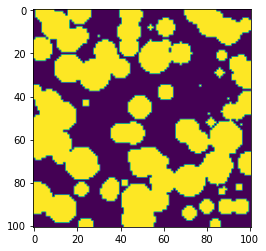

In [7]:
import random
solid = np.zeros((nx,nz))
porosityTarget=0.5; porosity=1.0
while porosity>porosityTarget:
    radius=random.random()*(nx//20+nx//30)
    xObst=int(random.random()*nx)
    zObst=int(random.random()*nz)
    for x in np.arange(nx):
        for z in np.arange(nz):
            if ((x-xObst)**2+(z-zObst)**2)<radius**2:
                solid[x,z]=1
    porosity=np.sum(1.0-solid)/(nx*nz)
plt.imshow(solid)
plt.show()

## Exercise 1
create your own routine to create a porous media. Create one that has a high porosity (>50%) and one wiht low porosity (<20%).

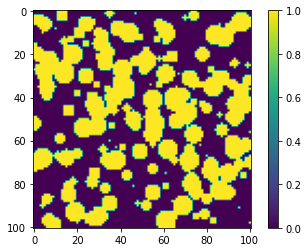

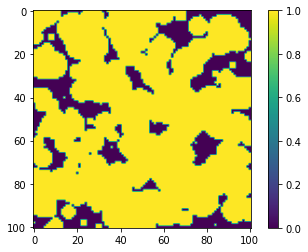

In [8]:
#here insert your solution
#High porosity
low_solid = np.zeros((nx,nz))
porosityTarget=0.55; porosity=1.0
while porosity>porosityTarget:
    #radius = .5 * (nx//35+nx//30)
    radius=random.random()*(nx//35+nx//30)
    xObst=int(random.random()*nx)
    zObst=int(random.random()*nz)
    for x in np.arange(nx):
        for z in np.arange(nz):
            if ((x-xObst)**2+(z-zObst)**2)<radius**2:
                low_solid[x,z]=1
    porosity=np.sum(1.0-low_solid)/(nx*nz)
plt.imshow(low_solid)
plt.colorbar()
plt.show()

##Low porosity
high_solid = np.zeros((nx,nz))
porosityTarget=0.19; porosity=1.0
while porosity>porosityTarget:
    #radius = .5*(nx//35+nx//35)
    radius=random.random()*(nx//20+nx//30)
    xObst=int(random.random()*nx)
    zObst=int(random.random()*nz)
    for x in np.arange(nx):
        for z in np.arange(nz):
            if ((x-xObst)**2+(z-zObst)**2)<radius**2:
                high_solid[x,z]=1
    porosity=np.sum(1.0-high_solid)/(nx*nz)
plt.imshow(high_solid)
plt.colorbar()
plt.show()

It helps future calculations to have Solid arrays that are shifted in the 8 directions respect to the original one:

In [9]:
#   Set increment arrays
_x_xa_ = np.zeros((na,nx),dtype=int)
_z_za_ = np.zeros((na,nz),dtype=int)
for a in range(na):
    for x in range(nx):
        x_xa = (x - c[a][0] + nx)%nx
        _x_xa_[a][x] = x_xa
    for z in range(nz):
        z_za = (z - c[a][1] + nz)%nz
        _z_za_[a][z] = z_za

for a in np.arange(na):
    for z in np.arange(nz):
        for x in np.arange(nx):
            if low_solid[_z_za_[a][z]][_x_xa_[a][x]]:
                Solid[a][z][x] = 1
            else:
                Solid[a][z][x] = 0          

## The solver loop

The Python time loop requires four steps: 

1. Imposing the Boundary Conditions (periodic in this example)
2. Calculating the streaming term for *f*
3. Calculating the macroscopic velocity term *u* and the new density *rho*
4. Calculating the equilibrium distribution *f_eq*, based on *u* and *rho*
5. Calculating the collision term *Delta_f* and add it to *f*

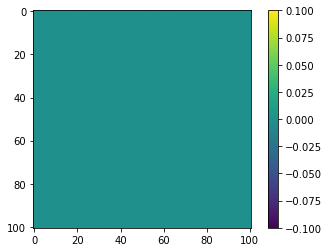

In [10]:
# Initialize the density, velocity and solid boolean
#f[0:na] = 1
u2 = np.einsum('ijk,ijk->jk', u, u)
for a in np.arange(na):
    f[a] = rho * w[a]
    cu = np.einsum('i,ijk->jk', c[a], u)
    for d in np.arange(D):
        f[a] += w[a]*(c2*c[a][d]*u[d] + c3*cu**2 + c4*u2)

myimg = plt.imshow(u2);plt.colorbar()

The entire loop requires only 20 lines of code:

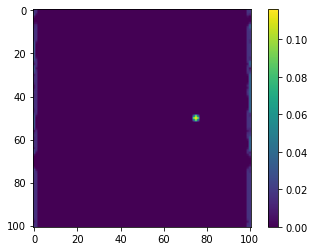

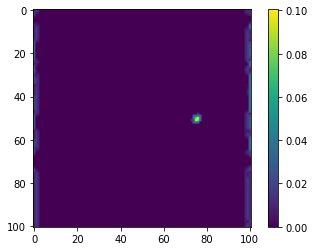

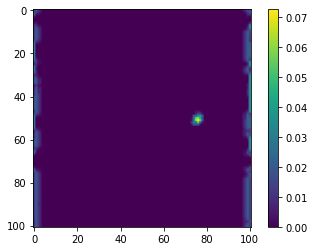

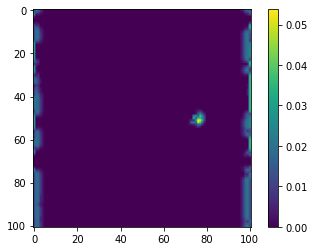

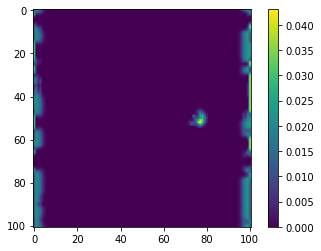

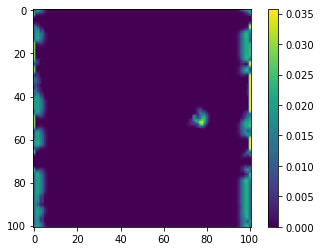

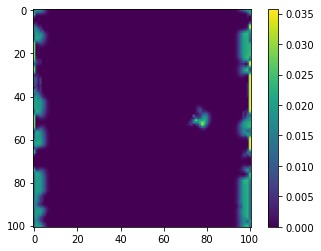

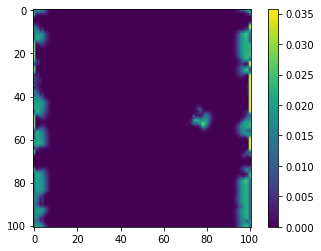

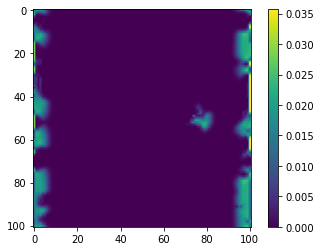

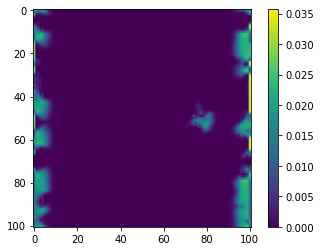

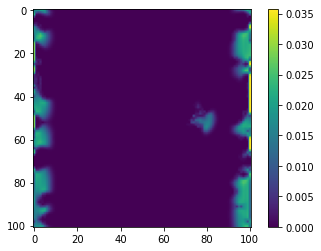

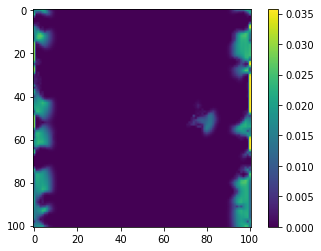

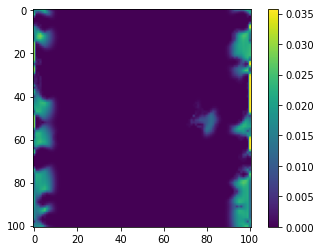

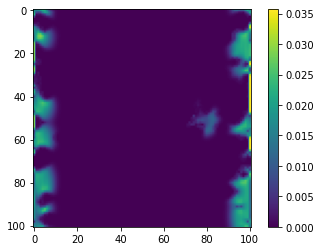

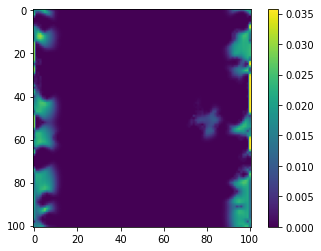

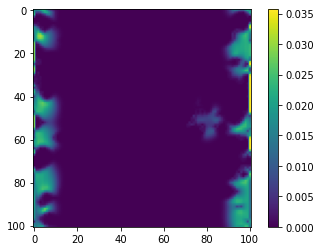

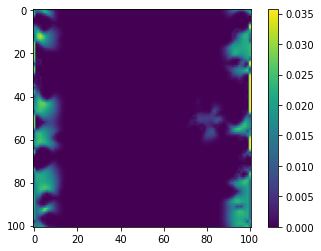

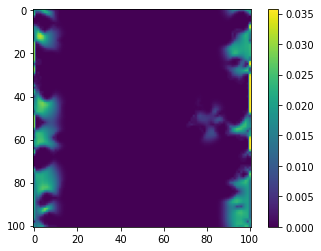

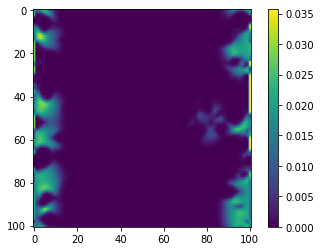

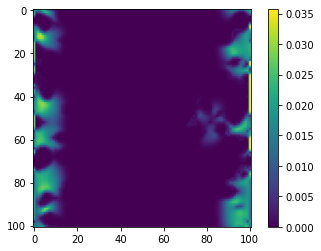

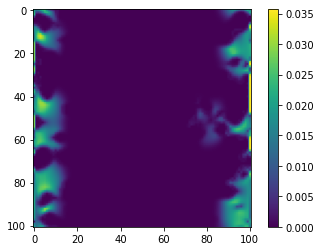

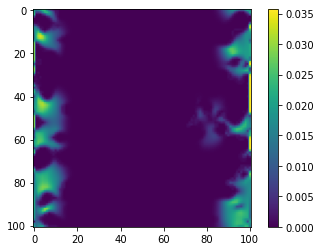

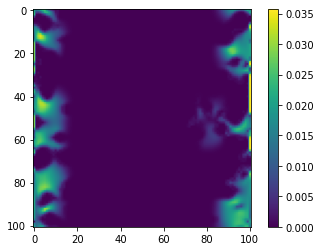

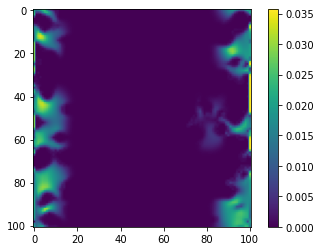

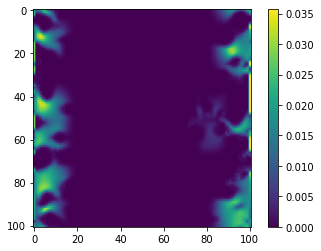

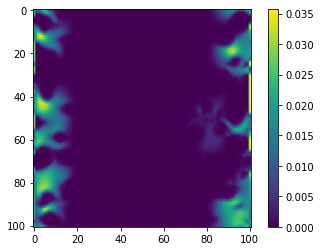

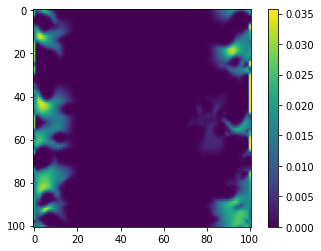

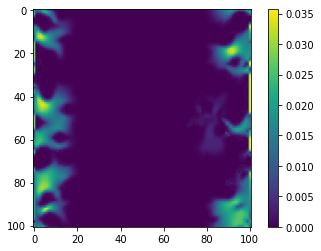

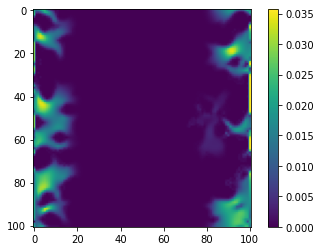

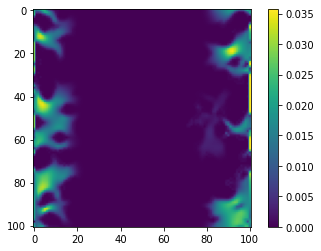

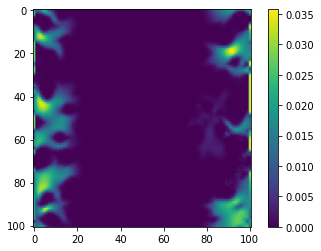

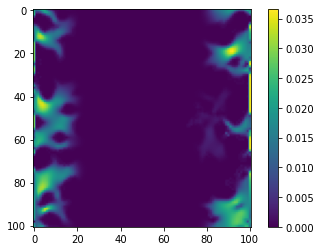

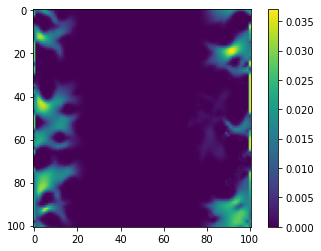

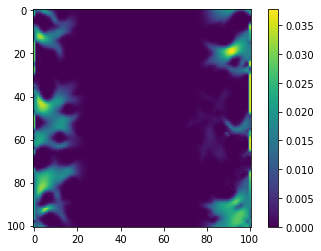

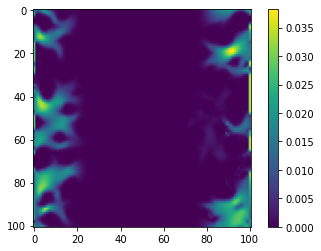

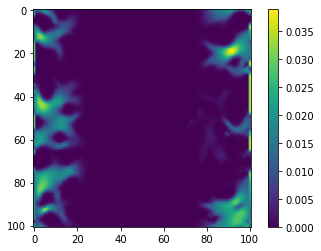

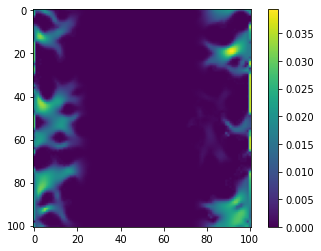

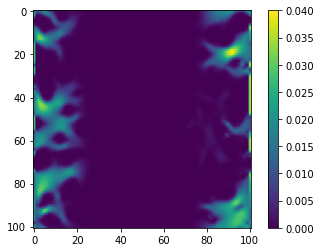

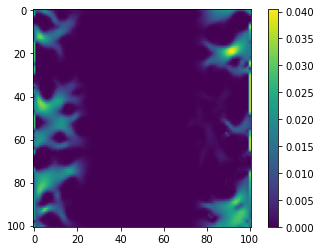

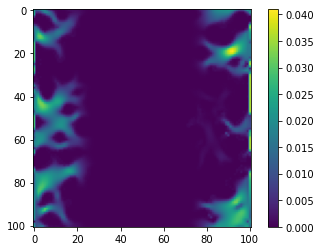

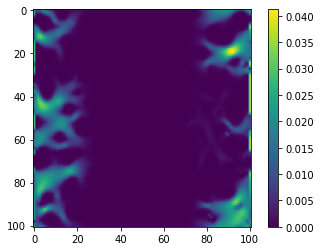

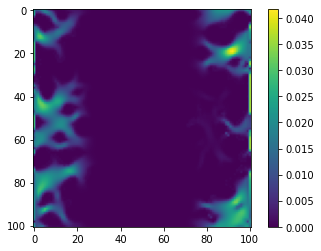

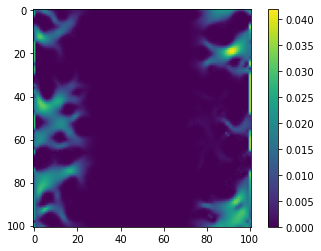

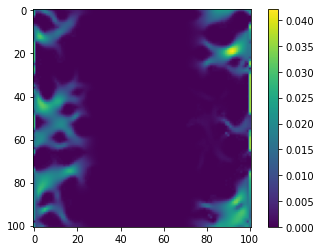

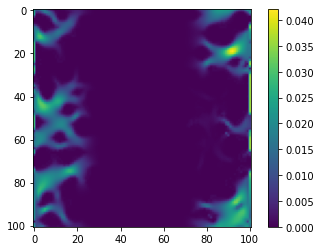

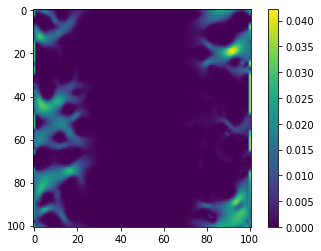

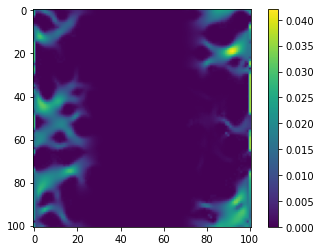

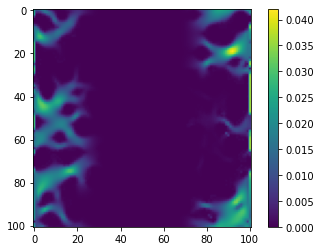

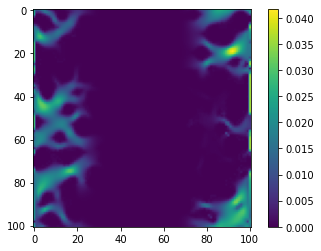

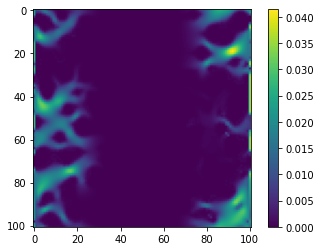

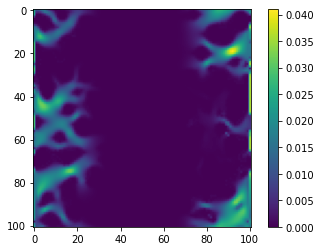

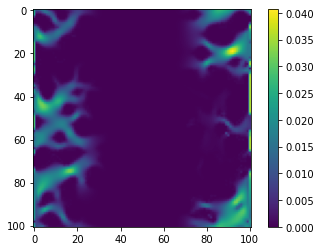

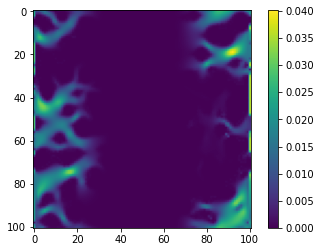

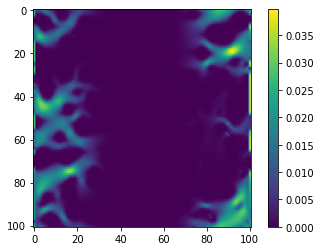

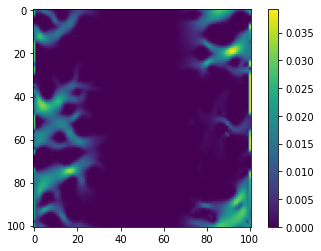

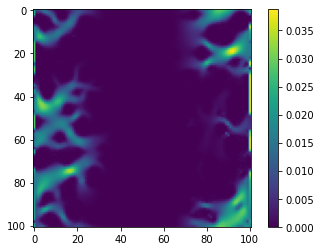

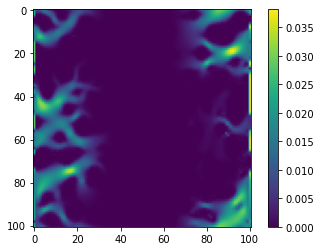

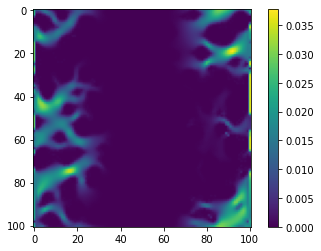

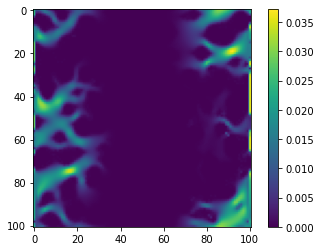

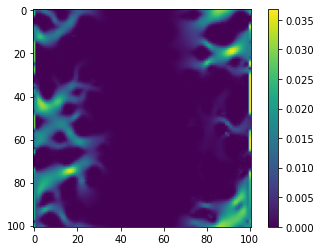

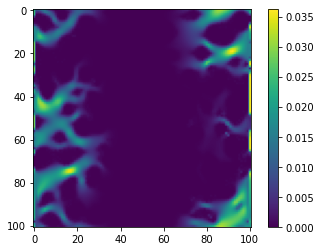

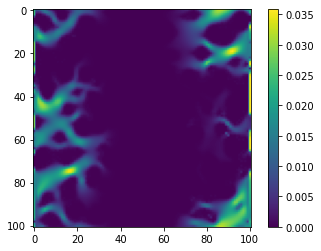

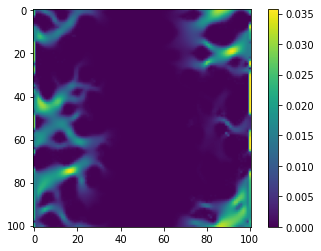

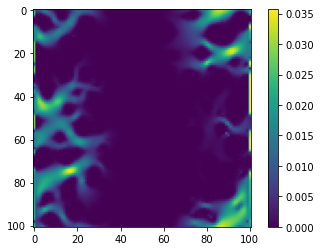

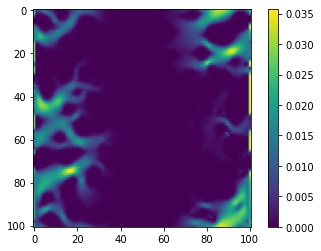

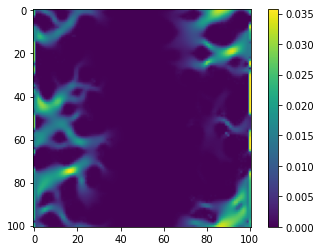

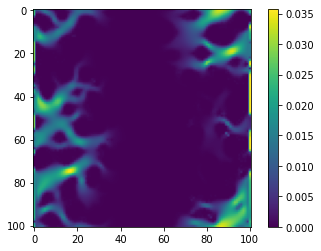

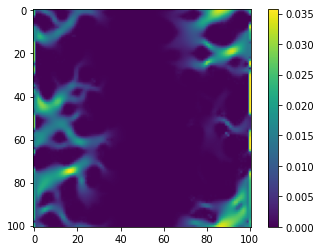

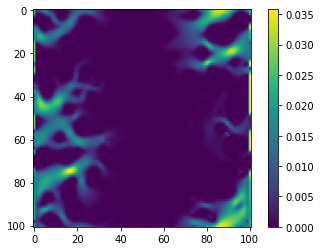

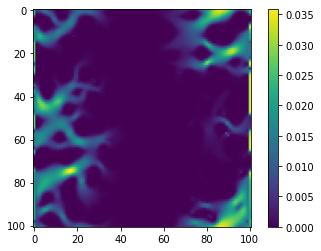

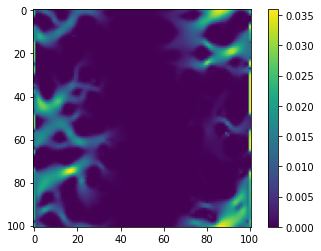

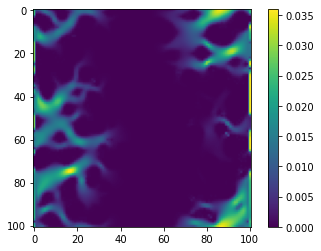

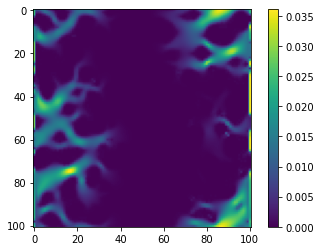

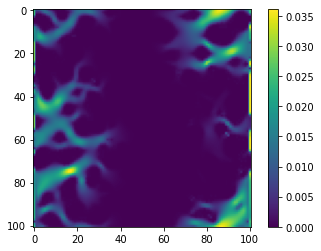

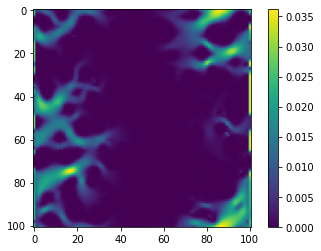

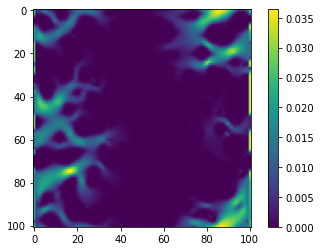

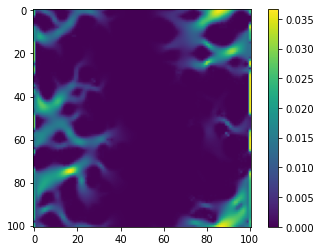

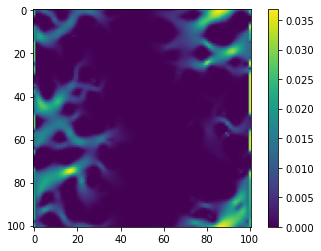

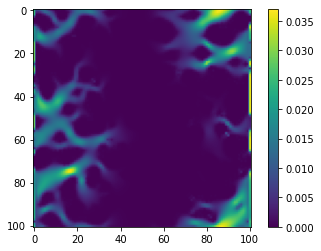

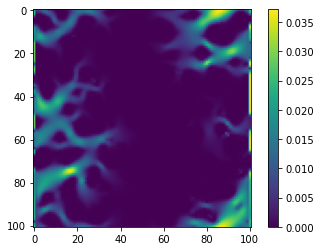

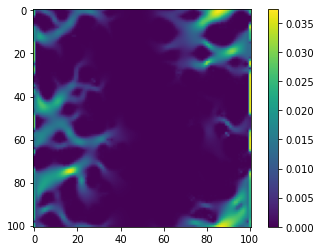

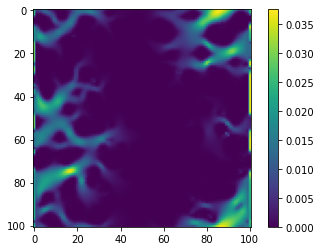

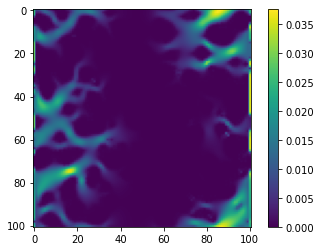

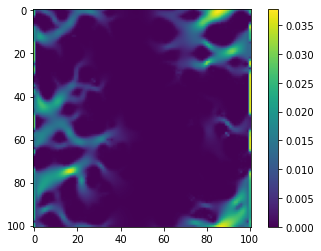

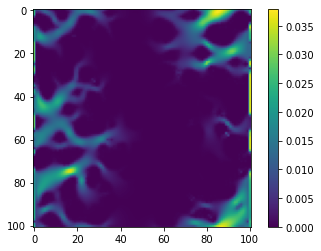

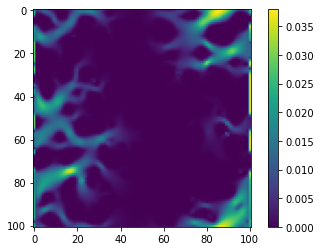

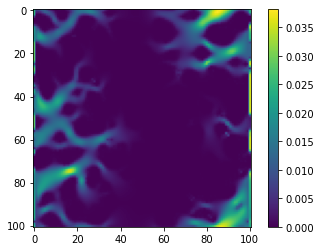

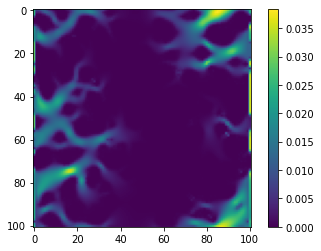

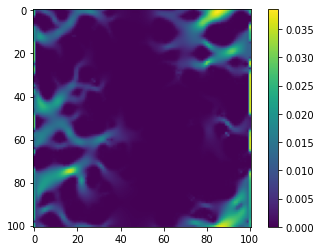

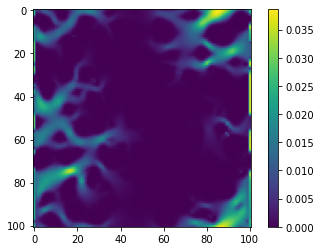

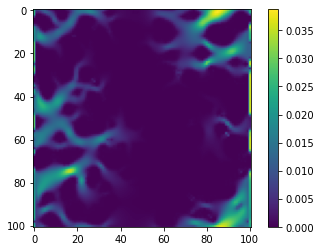

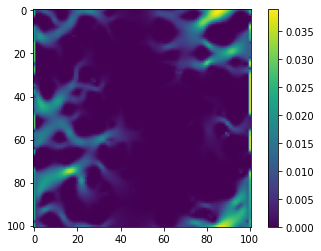

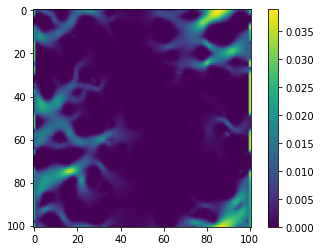

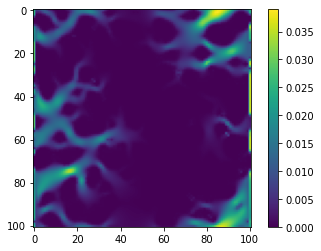

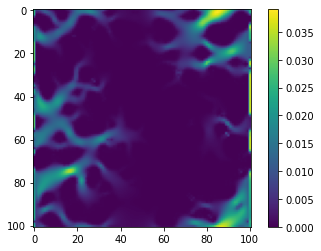

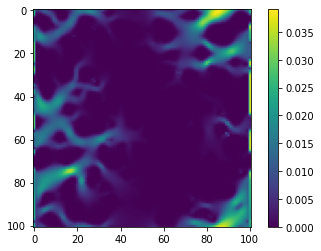

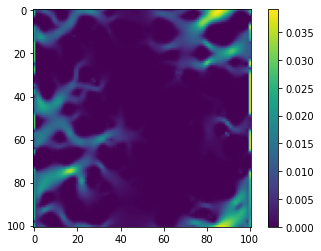

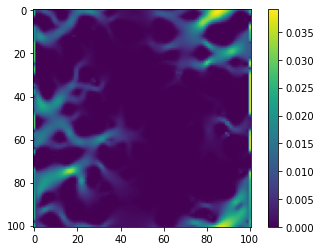

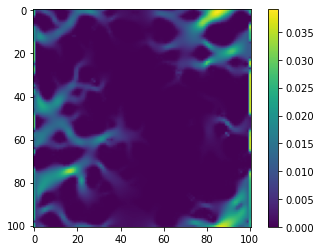

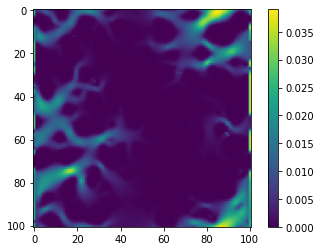

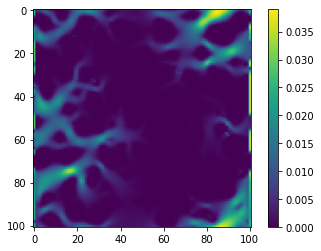

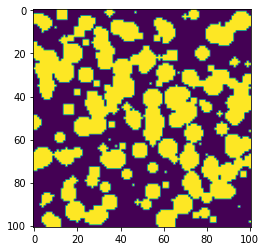

In [11]:
for t in np.arange(nt+1):
    
    #periodic BC for f
    #f[0:na,0:nz,0] = f[0:na,0:nz,-2]
    #f[0:na,0:nz,-1] = f[0:na,0:nz,1]

    for a in np.arange(na):
        f[a,0:nz,0]=rho_left*w[a]
        f[a,0:nz,-1]=rho_right*w[a]

    #streaming step    
    for a in np.arange(na): # Left  to right
        f_new = f[a].reshape(nx*nz)[indexes[a]]
        f_bounce = f[ai[a]]  #bounce back           
        f_stream[a] = Solid[a]*f_bounce + (1-Solid[a])*f_new.reshape(nz,nx)
    f = f_stream.copy()

#   Macroscopic properties
    rho = np.sum(f,axis=0)
    Pi = np.einsum('azx,ad->dzx',f,c)
    u[0:D]=Pi[0:D]/rho

#   Equilibrium distribution
    u2 = u[0]*u[0]+u[1]*u[1] #alternatives: np.einsum('ijk,ijk->jk', u, u) or np.linalg.norm(u,axis=0)**2
    for a in np.arange(na):
        cu = c[a][0]*u[0] + c[a][1]*u[1] #alternative: np.einsum('j,jkl->kl',c[a],u) #
        f_eq[a] = rho * w[a] * (c1 + c2*cu + c3*cu**2 + c4*u2)

#   Collision term
    Delta_f = (f_eq - f)/tau_f
    f += Delta_f

#let's plot the solution
    myimg = plt.imshow(np.sqrt(u2));plt.colorbar()
    plt.show() 

plt.imshow(low_solid)
plt.show()

We note the following important observations: 

1. The *indexes* array created above has been used in the definition of the new collision term $f_{new} = f[a].reshape(nx*nz)[indexes[a]]$. Here two *reshape()* instructions are used to change shape to the *f* array, but these do not consume any computing time, as they only refer to the internal structure of this array.

2. If in the instruction *f = f_stream.copy()*, *copy()* would be absent, then *f* would point to the memory allocated for *f_stream*, which then would be modified. 

3. In the instruction *Pi = np.einsum('azx,ad->dzx',f,c)* we used the function *np.einsum()*. This powerful tool allows one to perform any tensorial product, with any high-dimensional array, at the speed of the underlying C optimized code.

4. The instruction $u2 = u[0]*u[0]+u[1]*u[1]$ could be written using the Einstein summation function $np.einsum('ijk,ijk->jk', u, u)$ or by exploiting the linear algebra library of NumPy $np.linalg.norm(u,axis=0)**2$, but that would not accelerate the code. In the same way $cu = c[a][0]*u[0] + c[a][1]*u[1]$ could be written as $np.einsum('j,jkl->kl',c[a],u)$ but it would not accelerate the code. For both cases the vectorization of NumPy is equally fast. 

5. Separating the instructions $Delta_f = (f_eq - f)/tau_f$ and $f += Delta_f$ helps to avoid issues with the allocations of the NumPy array *f*. 


## Exercise 2
Benchmark separately the different parts of the code (streaming step, Macroscopic properties, etc) and find which one requires most time to run

In [12]:
'''
# here write your solution. copy and paste the loop and modify it in order to measure these quantities. 
# Can you plot the results?
import time
str_time = []
equil_time = []
collision_time = []

for t in np.arange(nt+1):
    
    #periodic BC for f
    #f[0:na,0:nz,0] = f[0:na,0:nz,-2]
    #f[0:na,0:nz,-1] = f[0:na,0:nz,1]

    for a in np.arange(na):
        f[a,0:nz,0]=rho_left*w[a]
        f[a,0:nz,-1]=rho_right*w[a]
        
    stream_time = time.time()
    #streaming step    
    for a in np.arange(na): # Left  to right
        f_new = f[a].reshape(nx*nz)[indexes[a]]
        f_bounce = f[ai[a]]  #bounce back           
        f_stream[a] = Solid[a]*f_bounce + (1-Solid[a])*f_new.reshape(nz,nx)
    f = f_stream.copy()
    str_time.append(time.time()-stream_time)
    
#   Macroscopic properties
    rho = np.sum(f,axis=0)
    Pi = np.einsum('azx,ad->dzx',f,c)
    u[0:D]=Pi[0:D]/rho

#   Equilibrium distribution
    eq_time = time.time()
    u2 = u[0]*u[0]+u[1]*u[1] #alternatives: np.einsum('ijk,ijk->jk', u, u) or np.linalg.norm(u,axis=0)**2
    for a in np.arange(na):
        cu = c[a][0]*u[0] + c[a][1]*u[1] #alternative: np.einsum('j,jkl->kl',c[a],u) #
        f_eq[a] = rho * w[a] * (c1 + c2*cu + c3*cu**2 + c4*u2)
    equil_time.append(time.time()-eq_time)
    
#   Collision term
    col_time = time.time()
    Delta_f = (f_eq - f)/tau_f
    f += Delta_f
    collision_time.append(time.time()-col_time)

#let's plot the solution
myimg = plt.imshow(np.sqrt(u2));plt.colorbar()
plt.show() 

plt.imshow(low_solid)
plt.show()

plt.plot(str_time, 'o-', label='stream')
plt.plot(equil_time, '.-', label='equilibrium')
plt.plot(collision_time, ',-', label='collision')
plt.legend()
plt.show()
'''

"\n# here write your solution. copy and paste the loop and modify it in order to measure these quantities. \n# Can you plot the results?\nimport time\nstr_time = []\nequil_time = []\ncollision_time = []\n\nfor t in np.arange(nt+1):\n    \n    #periodic BC for f\n    #f[0:na,0:nz,0] = f[0:na,0:nz,-2]\n    #f[0:na,0:nz,-1] = f[0:na,0:nz,1]\n\n    for a in np.arange(na):\n        f[a,0:nz,0]=rho_left*w[a]\n        f[a,0:nz,-1]=rho_right*w[a]\n        \n    stream_time = time.time()\n    #streaming step    \n    for a in np.arange(na): # Left  to right\n        f_new = f[a].reshape(nx*nz)[indexes[a]]\n        f_bounce = f[ai[a]]  #bounce back           \n        f_stream[a] = Solid[a]*f_bounce + (1-Solid[a])*f_new.reshape(nz,nx)\n    f = f_stream.copy()\n    str_time.append(time.time()-stream_time)\n    \n#   Macroscopic properties\n    rho = np.sum(f,axis=0)\n    Pi = np.einsum('azx,ad->dzx',f,c)\n    u[0:D]=Pi[0:D]/rho\n\n#   Equilibrium distribution\n    eq_time = time.time()\n    u2 = 

## Exercise 3
Create a strong anomaly in one point and turn the fluid dynamic code into a seismic propagation code (P waves only!)


time: 0


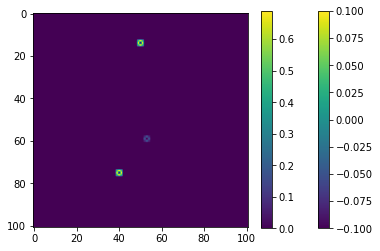

time: 10


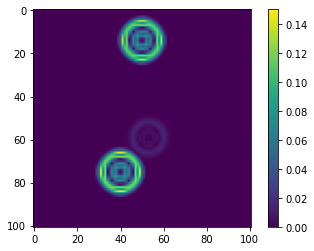

time: 20


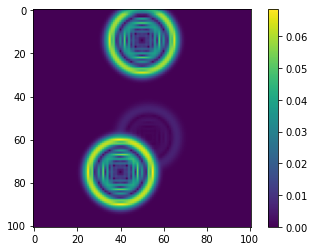

time: 30


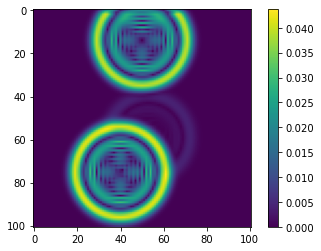

time: 40


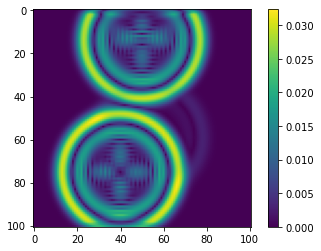

time: 50


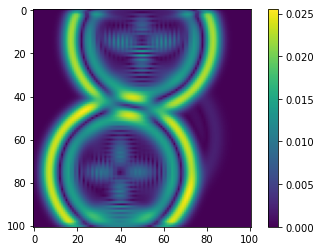

time: 60


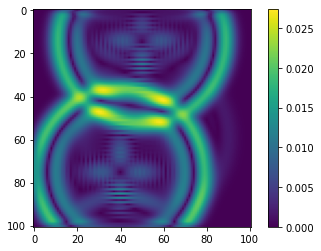

time: 70


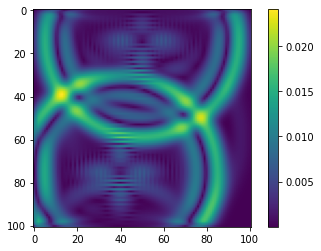

time: 80


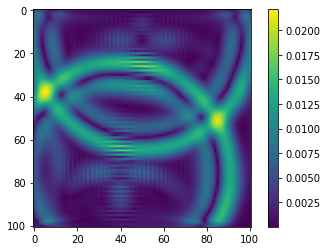

time: 90


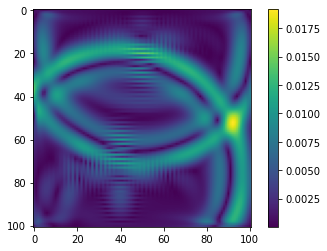

time: 100


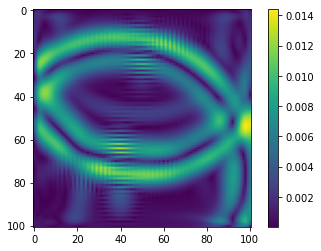

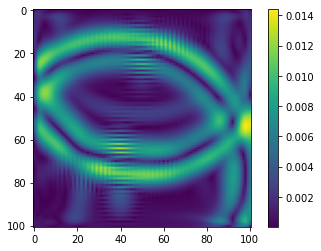

In [4]:
# here write your solution, for example with
# rho[nz//2,3*nx//4] = 2*rho_0
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm


#Block 1
na       = 9
c        = np.array([[ 0, 0],[ 1, 0],[-1, 0],[ 0, 1],[ 0,-1],[ 1, 1],[-1,-1],[ 1,-1],[-1, 1]]) # Right to left
ai       = np.array([  0   ,   2   ,   1   ,   4   ,   3   ,   6   ,   5   ,   8   ,   7  ]) #Reorders c for opposite directions
D        = 2 ##Dimension

#Block 2
##Weight Distribution for particle movement - weighted towards particles not moving -> corner in highest to lowest
w0 = 4.0/9.0
w1 = 1.0/9.0
w2 = 1.0/36.0

w  =  np.array([w0,w1,w1,w1,w1,w2,w2,w2,w2])

#Block 3
dt = 1
dx = 1
S  = dx/dt
c1 =  1.0
c2 =  3.0/(S**2)
c3 =  9.0/(2.0*S**4)
c4 = -3.0/(2.0*S**2)

# Initialize the relaxation time
nu_f         = 0.1        # Viscosity
tau_f = nu_f * 3./(S*dt) + 0.5


nt   =   100         # Number of time steps
nx   =   101          # X-axis size
nz   =   101          # Z-axis size

# new indexes for the vectorized streaming calculations
indexes = np.zeros((na,nx*nz),dtype=int)
for a in range(na):
    xArr = (np.arange(nx) - c[a][0] + nx)%nx
    zArr = (np.arange(nz) - c[a][1] + nz)%nz
    xInd,zInd=np.meshgrid(xArr,zArr)
    indTotal = zInd*nx + xInd
    indexes[a] = indTotal.reshape(nx*nz)
    
#Block 4                   
# Initialize arrays

f        = np.zeros((na,nz,nx))
f_stream = np.zeros((na,nz,nx))
f_stream1 = np.zeros((na,nz,nx))
f_stream2 = np.zeros((na,nz,nx))
f_bounce = np.zeros((na,nz,nx))
f_eq     = np.zeros((na,nz,nx))
Delta_f  = np.zeros((na,nz,nx))
#represents matrix of solids (0 = allowed, 1 = blocked)
solid    = np.zeros((nz,nx),dtype=bool)
Solid    = np.zeros((na,nz,nx),dtype=bool)

rho      = np.ones((nz,nx))
u        = np.zeros((D,nz,nx))
Pi       = np.zeros((D,nz,nx))
u2       = np.zeros((nz,nx))
xx       = np.arange(nx)
zz       = np.arange(nz)    
cu       = np.zeros((nz,nx))

#Block 5
# Initialize the density and the number densities

rho_0        = 1.0          # Density
rho     *= rho_0
rho_left=rho_0*1.0
rho_right=rho_0*1.0

rho[nz//7, nx//2] = 20*rho_0
rho[3*nz//4, 2*nx//5] = 21*rho_0
rho[random.randrange(0,100,1), random.randrange(0,100,1)] = 3*rho_0

#initialize f
for a in np.arange(na):
    f[a] = rho * w[a]
    
#Block 6
indexes = np.zeros((na,nx*nz),dtype=int)
for a in range(na):
    xArr       = (np.arange(nx) - c[a][0] + nx)%nx
    zArr       = (np.arange(nz) - c[a][1] + nz)%nz
    xInd,zInd  = np.meshgrid(xArr,zArr)
    indTotal   = zInd*nx + xInd
    indexes[a] = indTotal.reshape(nx*nz)   

#Block 7
import random
solid = np.zeros((nx,nz))
porosityTarget=1.0; porosity=1.0
while porosity>porosityTarget:
    radius=random.random()*(nx//20+nx//30)
    xObst=int(random.random()*nx)
    zObst=int(random.random()*nz)
    for x in np.arange(nx):
        for z in np.arange(nz):
            if ((x-xObst)**2+(z-zObst)**2)<radius**2:
                solid[x,z]=1
    porosity=np.sum(1.0-solid)/(nx*nz)

#Block 8
#   Set increment arrays
_x_xa_ = np.zeros((na,nx),dtype=int)
_z_za_ = np.zeros((na,nz),dtype=int)
for a in range(na):
    for x in range(nx):
        x_xa = (x - c[a][0] + nx)%nx
        _x_xa_[a][x] = x_xa
    for z in range(nz):
        z_za = (z - c[a][1] + nz)%nz
        _z_za_[a][z] = z_za

for a in np.arange(na):
    for z in np.arange(nz):
        for x in np.arange(nx):
            if solid[_z_za_[a][z]][_x_xa_[a][x]]:
                Solid[a][z][x] = 1
            else:
                Solid[a][z][x] = 0   

#Block 9
# Initialize the density, velocity and solid boolean
#f[0:na] = 1
u2 = np.einsum('ijk,ijk->jk', u, u)
for a in np.arange(na):
    f[a] = rho * w[a]
    cu = np.einsum('i,ijk->jk', c[a], u)
    for d in np.arange(D):
        f[a] += w[a]*(c2*c[a][d]*u[d] + c3*cu**2 + c4*u2)

myimg = plt.imshow(u2);plt.colorbar()

#Block 10
for t in np.arange(nt+1):
    
    #periodic BC for f
    #f[0:na,0:nz,0] = f[0:na,0:nz,-2]
    #f[0:na,0:nz,-1] = f[0:na,0:nz,1]

    for a in np.arange(na):
        f[a,0:nz,0]=rho_left*w[a]
        f[a,0:nz,-1]=rho_right*w[a]
        f[a,0,0:nz]=rho_right*w[a]
        f[a,-1,0:nz]=rho_right*w[a]

    #streaming step    
    for a in np.arange(na): # Left  to right
        f_new = f[a].reshape(nx*nz)[indexes[a]]
        f_bounce = f[ai[a]]  #bounce back           
        f_stream[a] = Solid[a]*f_bounce + (1-Solid[a])*f_new.reshape(nz,nx)
    f = f_stream.copy()

#   Macroscopic properties
    rho = np.sum(f,axis=0)
    Pi = np.einsum('azx,ad->dzx',f,c)
    u[0:D]=Pi[0:D]/rho

#   Equilibrium distribution
    u2 = u[0]*u[0]+u[1]*u[1] #alternatives: np.einsum('ijk,ijk->jk', u, u) or np.linalg.norm(u,axis=0)**2
    for a in np.arange(na):
        cu = c[a][0]*u[0] + c[a][1]*u[1] #alternative: np.einsum('j,jkl->kl',c[a],u) #
        f_eq[a] = rho * w[a] * (c1 + c2*cu + c3*cu**2 + c4*u2)

#   Collision term
    Delta_f = (f_eq - f)/tau_f
    f += Delta_f
    
    
#let's plot the solution
#    if t> 0 and t<=25:
#        print("time: " + str(t))
#        myimg = plt.imshow(np.sqrt(u2)); plt.colorbar()
#        plt.show()
        
    if t%10 == 0:
        print("time: " + str(t))
        myimg = plt.imshow(np.sqrt(u2));plt.colorbar()
        plt.show() 
plt.imshow(np.sqrt(u2))
plt.colorbar()
plt.show()
#plt.imshow(solid)
#plt.imshow(solid+np.sqrt(u2))
#plt.colorbar()
#plt.show()